In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# runtime: Python 3, GPU
!nvidia-smi
#!pip install -q ultralytics==8.0.149  # or latest stable
!pip install -q roboflow


Sat Jan 10 10:51:32 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os, textwrap, yaml



DATASET_PATH = "/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset"


CLASS_NAMES = ['good','scratch','dent']

# Create data.yaml for YOLOv8
data = {
    'path': DATASET_PATH,
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': CLASS_NAMES
}

os.makedirs(DATASET_PATH, exist_ok=True)
with open(os.path.join(DATASET_PATH, 'data.yaml'), 'w') as f:
    yaml.dump(data, f)

print("Wrote data.yaml to", os.path.join(DATASET_PATH, 'data.yaml'))
print("---")
print(open(os.path.join(DATASET_PATH, 'data.yaml')).read())


Wrote data.yaml to /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset/data.yaml
---
names:
- good
- scratch
- dent
path: /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset
test: images/test
train: images/train
val: images/val



In [ ]:
import glob, os
for split in ['train','val','test']:
    imgs = glob.glob(os.path.join(DATASET_PATH, 'images', split, '*'))
    lbls = glob.glob(os.path.join(DATASET_PATH, 'labels', split, '*'))
    print(f"{split}: images={len(imgs)}, labels={len(lbls)}")

# show any images without matching label (for negative samples leave label absent or empty)
missing_lbl = []
for img in glob.glob(os.path.join(DATASET_PATH, 'images', 'train', '*')):
    base = os.path.splitext(os.path.basename(img))[0]
    if not os.path.exists(os.path.join(DATASET_PATH, 'labels', 'train', base + '.txt')):
        missing_lbl.append(base)
print("Some training images missing label files (okay if they are negative samples):", len(missing_lbl))


train: images=240, labels=240
val: images=30, labels=30
test: images=30, labels=30
Some training images missing label files (okay if they are negative samples): 0


In [ ]:
print(f"Listing contents of DATASET_PATH: {DATASET_PATH}")
!ls -R "{DATASET_PATH}" || echo "Directory not found or accessible: {DATASET_PATH}"


Listing contents of DATASET_PATH: /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset
/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset:
classes.txt  data.yaml	labels	      split_dataset.py
dataset_raw  images	metadata.csv  verify_labels.py

/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset/dataset_raw:

/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset/images:
test  train  val

/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset/images/test:
gear_dent_Gear_dent_2.png   gear_good_gear_gud_64.png
gear_den

In [ ]:
# load the trained model

import random, os
train_imgs = os.listdir(os.path.join(DATASET_PATH, 'images', 'train'))
sample = random.sample(train_imgs, min(5, len(train_imgs)))
for s in sample:
    base = os.path.splitext(s)[0]
    lbl_path = os.path.join(DATASET_PATH, 'labels', 'train', base + '.txt')
    print(s, "->", "label exists" if os.path.exists(lbl_path) else "no label") # bounding box locations
    if os.path.exists(lbl_path):
        print("  ", open(lbl_path).read().strip())


gear_scratch_Gear_scratch_45.png -> label exists
   1 0.443898 0.143503 0.080709 0.031638
gear_scratch_Gear_scratch_53.png -> label exists
   1 0.598425 0.319209 0.041995 0.041808
gear_dent_Gear_dent_11.png -> label exists
   2 0.328856 0.465254 0.024876 0.045763
gear_dent_Gear_dent_4.png -> label exists
   2 0.424310 0.200762 0.025354 0.053367
gear_scratch_Gear_scratch_27.png -> label exists
   1 0.582349 0.317514 0.054462 0.040678


In [ ]:
# upgrade ultralytics
!pip install -U ultralytics

# Ensuring a compatible torch is installed
!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.2 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
# show if a local file exists
!ls -l yolov8s.pt || true
# if it exists, remove it so the CLI downloads the correct hub weights
!rm -f yolov8s.pt


ls: cannot access 'yolov8s.pt': No such file or directory


In [ ]:
# Parameters
MODEL="yolov8s.pt"
EPOCHS=20
IMGSZ=640
BATCH=16            # can be altered
WORKDIR="/content/runs"   # where results will be stored
weights_only="True"
# Train using ultralytics 'yolo' CLI
!yolo detect train data="{DATASET_PATH}/data.yaml" model={MODEL} epochs={EPOCHS} imgsz={IMGSZ} batch={BATCH} project={WORKDIR} name="yolo_train_noaug" exist_ok=True


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.251 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, form

In [ ]:
from ultralytics import YOLO
import os

# Path to the best trained model weights
model_path = os.path.join(WORKDIR, 'yolo_train_noaug', 'weights', 'best.pt')

# Load the custom model
model = YOLO(model_path)

print(f"Model loaded from: {model_path}")


Model loaded from: /content/runs/yolo_train_noaug/weights/best.pt


Classifying image: /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset/images/test/gear_dent_Gear_dent_34.png

image 1/1 /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset/images/test/gear_dent_Gear_dent_34.png: 384x640 1 dent, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


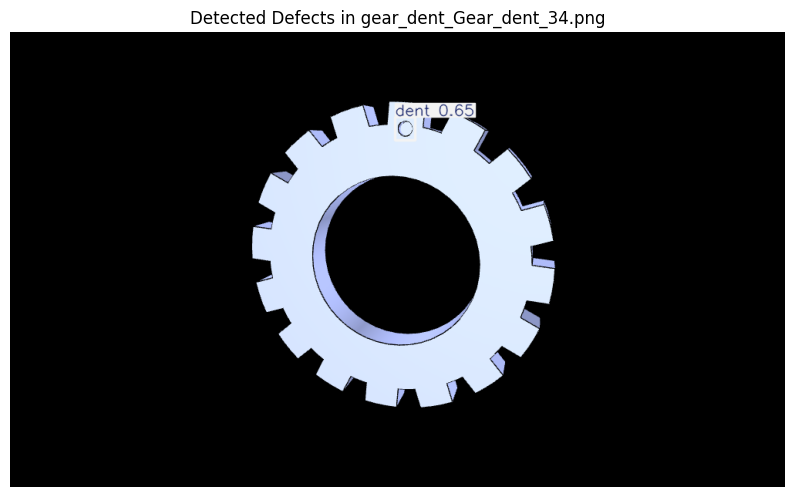

Detected defects:
- dent (Confidence: 0.65)


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Example image path from the test set
image_to_classify_path = os.path.join(DATASET_PATH, 'images', 'test', 'gear_dent_Gear_dent_34.png')

print(f"Classifying image: {image_to_classify_path}")

# Run inference on the image
results = model(image_to_classify_path)

# Process results
for r in results:
    # Plot results on the image
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image

    # Display the image with predictions
    plt.figure(figsize=(10, 10))
    plt.imshow(im)
    plt.axis('off')
    plt.title(f"Detected Defects in {os.path.basename(image_to_classify_path)}")
    plt.show()

    # Print detected classes and confidence scores
    if len(r.boxes) == 0:
        print("No defects detected.")
    else:
        print("Detected defects:")
        for box in r.boxes:
            class_id = int(box.cls[0])
            conf = box.conf[0]
            defect_name = CLASS_NAMES[class_id] #
            print(f"- {defect_name} (Confidence: {conf:.2f})")


**YOLOv8 — Inference Latency Measurement(single image)**

In [ ]:
from ultralytics import YOLO
import time
import numpy as np

model = YOLO("/content/runs/yolo_train_noaug/weights/best.pt")   # your trained YOLOv8 model
image_path = "/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/image_classification_dataset/test/dent/gear_dent_Gear_dent_2.png"

latencies = []

# Warm-up
for _ in range(5):
    model(image_path, verbose=False)

# Timed runs
for _ in range(30):
    start = time.perf_counter()
    _ = model(image_path, verbose=False)
    end = time.perf_counter()
    latencies.append((end - start) * 1000)  # ms

avg_latency = np.mean(latencies)
std_latency = np.std(latencies)

print(f"YOLOv8 Avg Inference Latency: {avg_latency:.2f} ms ± {std_latency:.2f} ms")



YOLOv8 Avg Inference Latency: 25.71 ms ± 2.73 ms


**YOLOv8 — Inference Latency Measurement(testset)**

YOLOv8 Avg Latency: 21.87 ms
YOLOv8 Std Latency: 2.83 ms


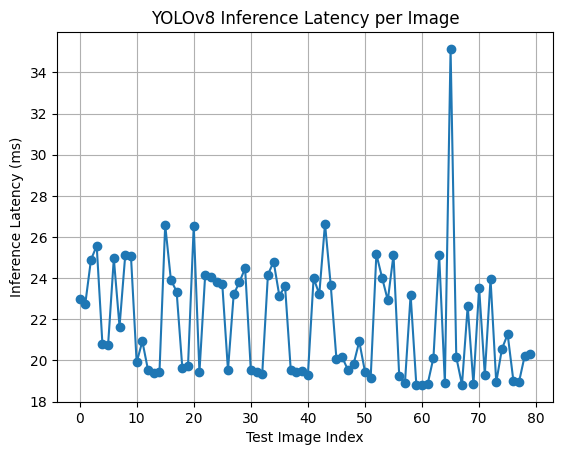

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Paths
MODEL_PATH = "/content/runs/yolo_train_noaug/weights/best.pt"
TEST_IMG_DIR = "/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/image_classification_dataset/train/dent"

# Load model
model = YOLO(MODEL_PATH)

# Get image list
image_files = [os.path.join(TEST_IMG_DIR, f)
               for f in os.listdir(TEST_IMG_DIR)
               if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

latencies = []

# Warm-up
for _ in range(5):
    _ = model(image_files[0], verbose=False)

# Measure latency
for img_path in image_files:
    start = time.perf_counter()
    _ = model(img_path, verbose=False)
    end = time.perf_counter()
    latencies.append((end - start) * 1000)  # ms

yolo_latencies = np.array(latencies)

print(f"YOLOv8 Avg Latency: {yolo_latencies.mean():.2f} ms")
print(f"YOLOv8 Std Latency: {yolo_latencies.std():.2f} ms")

# Plot
plt.figure()
plt.plot(yolo_latencies, marker='o')
plt.xlabel("Test Image Index")
plt.ylabel("Inference Latency (ms)")
plt.title("YOLOv8 Inference Latency per Image")
plt.grid(True)
plt.show()


 **Evaluation Plots**

Available metrics in results.csv: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


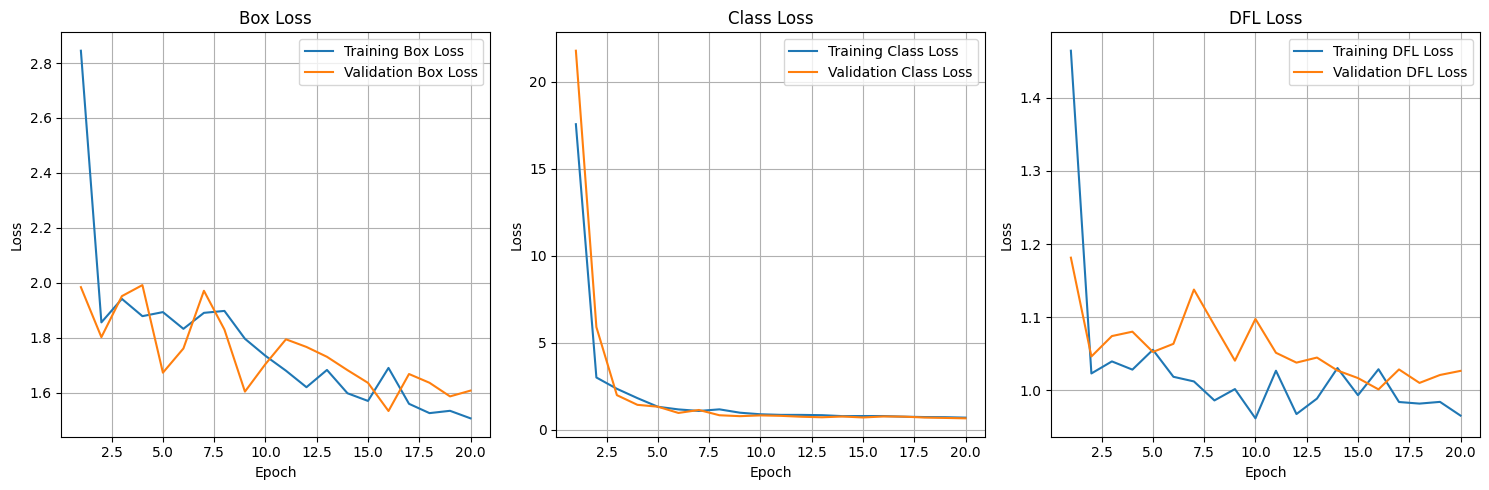

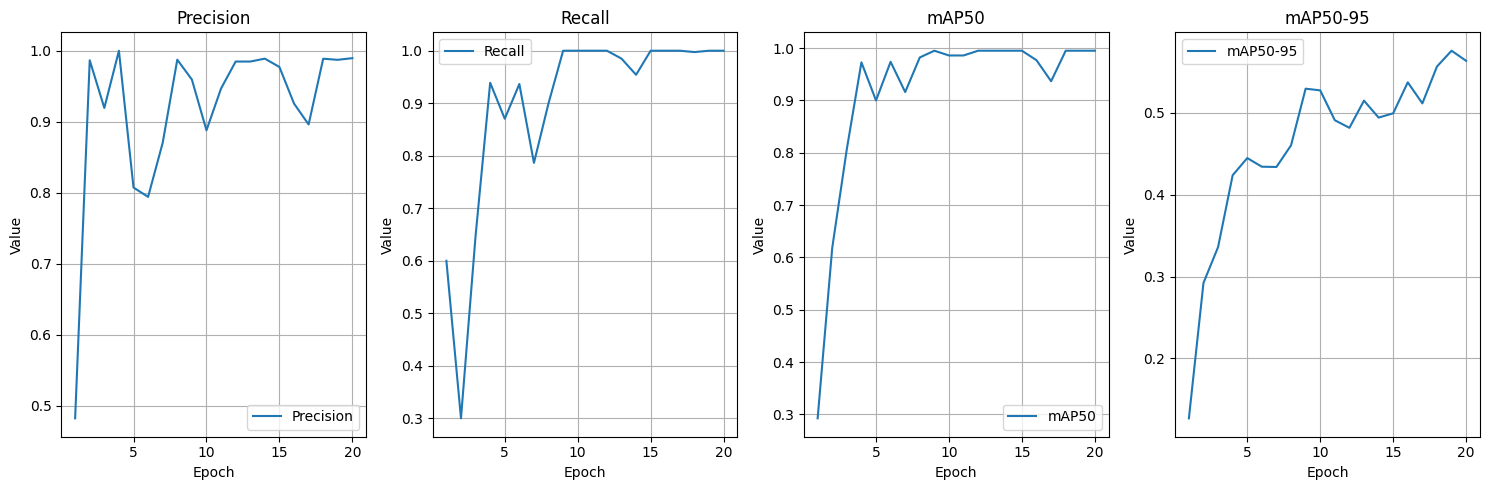

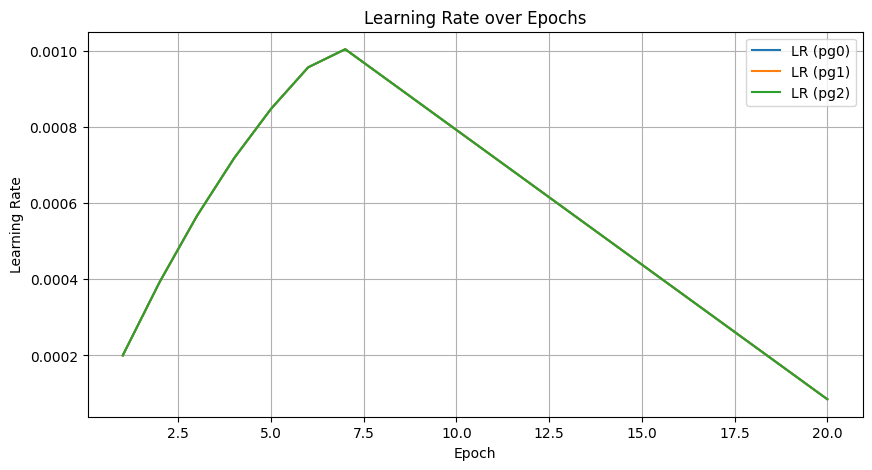

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Construct the path to the results.csv file
results_path = os.path.join(WORKDIR, 'yolo_train_noaug', 'results.csv')

# Check if the results.csv file exists
if not os.path.exists(results_path):
    print(f"Error: results.csv not found at {results_path}")
else:
    # Read the results.csv file into a pandas DataFrame
    try:
        results_df = pd.read_csv(results_path, sep=',')
    except Exception:
        results_df = pd.read_csv(results_path, sep=' ')

    # Display columns to confirm available metrics
    print("Available metrics in results.csv:", results_df.columns.tolist())

    # Plotting Loss Metrics
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Training Box Loss')
    plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Validation Box Loss')
    plt.title('Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Training Class Loss')
    plt.plot(results_df['epoch'], results_df['val/cls_loss'], label='Validation Class Loss')
    plt.title('Class Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(results_df['epoch'], results_df['train/dfl_loss'], label='Training DFL Loss')
    plt.plot(results_df['epoch'], results_df['val/dfl_loss'], label='Validation DFL Loss')
    plt.title('DFL Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plotting Accuracy/Performance Metrics
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 2)
    plt.plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 3)
    plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP50')
    plt.title('mAP50')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 4)
    plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP50-95')
    plt.title('mAP50-95')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plotting Learning Rate
    plt.figure(figsize=(10, 5))
    plt.plot(results_df['epoch'], results_df['lr/pg0'], label='LR (pg0)')
    plt.plot(results_df['epoch'], results_df['lr/pg1'], label='LR (pg1)')
    plt.plot(results_df['epoch'], results_df['lr/pg2'], label='LR (pg2)')
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Classification with MobileNetv2
Prepare the dataset for image classification by organizing images into subfolders based on their class (good, scratch, dent) within train, validation, and test splits.

In [ ]:
import os
import shutil

# 1. Define a new variable for the image classification dataset path
IMAGE_CLASSIFICATION_DATASET_PATH = os.path.join(
    os.path.dirname(DATASET_PATH), "mobilenet_dataset"
)

# 2. Create the base directory for the IMAGE_CLASSIFICATION_DATASET_PATH
os.makedirs(IMAGE_CLASSIFICATION_DATASET_PATH, exist_ok=True)

print(f"Created base directory for image classification dataset: {IMAGE_CLASSIFICATION_DATASET_PATH}")

# 3. For each data split ('train', 'val', 'test'), create subdirectories
for split in ['train', 'val', 'test']:
    for class_name in CLASS_NAMES:
        split_class_dir = os.path.join(IMAGE_CLASSIFICATION_DATASET_PATH, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        print(f"Created directory: {split_class_dir}")

# 4. Iterate through each image file in the 'images' subdirectory of the original YOLO dataset
for split in ['train', 'val', 'test']:
    print(f"\nProcessing split: {split}")
    original_images_dir = os.path.join(DATASET_PATH, 'images', split)
    original_labels_dir = os.path.join(DATASET_PATH, 'labels', split)

    image_files = os.listdir(original_images_dir)

    for img_filename in image_files:
        img_name, img_ext = os.path.splitext(img_filename)
        original_img_path = os.path.join(original_images_dir, img_filename)
        label_file_path = os.path.join(original_labels_dir, img_name + '.txt')

        detected_class = 'good' # Default to 'good'

        # 6. Read the content of the label file and determine the image's class
        if os.path.exists(label_file_path):
            with open(label_file_path, 'r') as f:
                labels_content = f.read().strip()

            if labels_content:
                # Parse class IDs from bounding box annotations
                class_ids_in_image = set()
                for line in labels_content.split('\n'):
                    try:
                        class_id = int(line.split(' ')[0])
                        class_ids_in_image.add(class_id)
                    except (ValueError, IndexError):
                        continue # Skip malformed lines

                # Determine class based on precedence (scratch then dent)
                if CLASS_NAMES.index('scratch') in class_ids_in_image:
                    detected_class = 'scratch'
                elif CLASS_NAMES.index('dent') in class_ids_in_image:
                    detected_class = 'dent'

            else:
                # Label file is empty, classify as 'good'
                detected_class = 'good'
        else:
            # No label file exists, classify as 'good' (assuming negative samples)
            detected_class = 'good'

        # 7. Copy the image to the newly created class-specific subdirectory
        destination_dir = os.path.join(IMAGE_CLASSIFICATION_DATASET_PATH, split, detected_class)
        shutil.copy(original_img_path, destination_dir)
        # print(f"Copied {img_filename} to {os.path.join(split, detected_class)}")

print("\nDataset reorganization for image classification complete.")

Created base directory for image classification dataset: /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/mobilenet_dataset
Created directory: /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/mobilenet_dataset/train/good
Created directory: /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/mobilenet_dataset/train/scratch
Created directory: /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/mobilenet_dataset/train/dent
Created directory: /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/mobilenet_dataset/val/good
Created directory: /content

**Verification for reorganised dataset**:




In [ ]:
print(f"Listing contents of IMAGE_CLASSIFICATION_DATASET_PATH: {IMAGE_CLASSIFICATION_DATASET_PATH}")
!ls -R "{IMAGE_CLASSIFICATION_DATASET_PATH}"

# Verify counts for each class and split
print("\nVerifying image counts:")
for split in ['train', 'val', 'test']:
    print(f"\n--- {split.upper()} ---")
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(IMAGE_CLASSIFICATION_DATASET_PATH, split, class_name)
        if os.path.exists(class_dir):
            num_images = len(os.listdir(class_dir))
            print(f"{class_name}: {num_images} images")
        else:
            print(f"{class_name}: Directory not found")


Listing contents of IMAGE_CLASSIFICATION_DATASET_PATH: /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/mobilenet_dataset
/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/mobilenet_dataset:
test  train  val

/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/mobilenet_dataset/test:
dent  good  scratch

/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/mobilenet_dataset/test/dent:
gear_dent_Gear_dent_2.png   gear_dent_Gear_dent_55.png
gear_dent_Gear_dent_31.png  gear_dent_Gear_dent_5.png
gear_dent_Gear_dent_34.png  gear_dent_Gear_dent_72.png
gear_dent_Gear_dent_39.png  gear_dent_Gear_dent_95.png
gear_dent_Gear_dent_48.png  gear_

## Load Dataset and Define Transforms

Load the newly structured image classification dataset using `torchvision.datasets.ImageFolder` for PyTorch, and define appropriate transformations (e.g., resizing, cropping, normalization) for MobileNetV2.


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define image transformations for MobileNetV2


# Training transformations (with data augmentation)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # Randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
    transforms.ToTensor(),             # Convert PIL Image or numpy array to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])

# Validation and Test transformations (without data augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize(256),            # Resize to 256x256
    transforms.CenterCrop(224),        # Crop the center to 224x224
    transforms.ToTensor(),             # Convert PIL Image or numpy array to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])

# Load the datasets
train_dataset = datasets.ImageFolder(
    root=os.path.join(IMAGE_CLASSIFICATION_DATASET_PATH, 'train'),
    transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root=os.path.join(IMAGE_CLASSIFICATION_DATASET_PATH, 'val'),
    transform=val_test_transforms
)

test_dataset = datasets.ImageFolder(
    root=os.path.join(IMAGE_CLASSIFICATION_DATASET_PATH, 'test'),
    transform=val_test_transforms
)

# Define DataLoader parameters
BATCH_SIZE = 32
NUM_WORKERS = 4 # Number of subprocesses to use for data loading

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

print("Datasets loaded and DataLoaders created successfully.")
print(f"Training dataset size: {len(train_dataset)} images")
print(f"Validation dataset size: {len(val_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Class names: {train_dataset.classes}")

Datasets loaded and DataLoaders created successfully.
Training dataset size: 240 images
Validation dataset size: 30 images
Test dataset size: 30 images
Number of classes: 3
Class names: ['dent', 'good', 'scratch']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define image transformations for MobileNetV2


# Training transformations (with data augmentation)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # Randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
    transforms.ToTensor(),             # Convert PIL Image or numpy array to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])

# Validation and Test transformations (without data augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize(256),            # Resize to 256x256
    transforms.CenterCrop(224),        # Crop the center to 224x224
    transforms.ToTensor(),             # Convert PIL Image or numpy array to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])

# Load the datasets
train_dataset = datasets.ImageFolder(
    root=os.path.join(IMAGE_CLASSIFICATION_DATASET_PATH, 'train'),
    transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root=os.path.join(IMAGE_CLASSIFICATION_DATASET_PATH, 'val'),
    transform=val_test_transforms
)

test_dataset = datasets.ImageFolder(
    root=os.path.join(IMAGE_CLASSIFICATION_DATASET_PATH, 'test'),
    transform=val_test_transforms
)

# Define DataLoader parameters
BATCH_SIZE = 32
NUM_WORKERS = 2 # Number of subprocesses to use for data loading, adjusted to avoid warning

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

print("Datasets loaded and DataLoaders created successfully.")
print(f"Training dataset size: {len(train_dataset)} images")
print(f"Validation dataset size: {len(val_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Class names: {train_dataset.classes}")

Datasets loaded and DataLoaders created successfully.
Training dataset size: 240 images
Validation dataset size: 30 images
Test dataset size: 30 images
Number of classes: 3
Class names: ['dent', 'good', 'scratch']


## Define MobileNetV2 Model


Load a pre-trained MobileNetV2 model (from `torchvision.models` or similar library), and modify its final classification layer to match the number of classes in your dataset (good, scratch, dent).


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# 1. Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load a pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# 3. Freeze all parameters in the loaded model
for param in model.parameters():
    param.requires_grad = False

# 4. Replace the original classifier head with a new fully connected layer
in_features = model.classifier[1].in_features
num_classes = len(train_dataset.classes) # Use the number of classes determined from the dataset
model.classifier[1] = nn.Linear(in_features, num_classes)

# 5. Move the modified model to the appropriate device
model = model.to(device)

# 6. Print the modified model architecture
print("\nModified MobileNetV2 Model Architecture:")
print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 162MB/s]


Modified MobileNetV2 Model Architecture:
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=

**Define the loss function and optimizer**:




In [ ]:
import torch.optim as optim

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss() #
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

print("Loss function (CrossEntropyLoss) and Optimizer (Adam) defined.")
print(f"Optimizer is set to update parameters of: {list(optimizer.param_groups[0]['params'])}")

Loss function (CrossEntropyLoss) and Optimizer (Adam) defined.
Optimizer is set to update parameters of: [Parameter containing:
tensor([[ 0.0262, -0.0227, -0.0132,  ...,  0.0279, -0.0242,  0.0208],
        [-0.0259, -0.0058,  0.0230,  ..., -0.0092, -0.0194, -0.0173],
        [-0.0039, -0.0148, -0.0189,  ...,  0.0244,  0.0087, -0.0271]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.0136,  0.0229, -0.0259], device='cuda:0', requires_grad=True)]


In [ ]:
import time
import copy

# Function to train the model
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

print("Training and validation functions defined.")

Training and validation functions defined.


**Model Training**:




In [ ]:
import time

# Train the model
num_epochs = 20  # Define the number of epochs for training

print("Starting model training...")
model_ft = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)
print("Model training complete.")

# Evaluate the trained model on the test set
def evaluate_model(model, test_loader, criterion):
    model.eval() # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0

    all_preds = []
    all_labels = []

    with torch.no_grad(): # Disable gradient calculation during evaluation
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}')
    return test_acc, all_labels, all_preds

print("\nEvaluating model on the test set...")
test_accuracy, true_labels, predictions = evaluate_model(model_ft, test_loader, criterion)
print("Model evaluation complete.")

Starting model training...
Epoch 0/19
----------
train Loss: 0.8494 Acc: 0.5750
val Loss: 0.7485 Acc: 0.8000

Epoch 1/19
----------
train Loss: 0.7224 Acc: 0.6833
val Loss: 0.5929 Acc: 0.7667

Epoch 2/19
----------
train Loss: 0.5645 Acc: 0.7833
val Loss: 0.4743 Acc: 0.9333

Epoch 3/19
----------
train Loss: 0.5351 Acc: 0.7958
val Loss: 0.3764 Acc: 0.9333

Epoch 4/19
----------
train Loss: 0.5165 Acc: 0.8083
val Loss: 0.3259 Acc: 0.9667

Epoch 5/19
----------
train Loss: 0.4593 Acc: 0.8542
val Loss: 0.3090 Acc: 0.9667

Epoch 6/19
----------
train Loss: 0.4666 Acc: 0.8208
val Loss: 0.2911 Acc: 0.9667

Epoch 7/19
----------
train Loss: 0.3947 Acc: 0.8583
val Loss: 0.2688 Acc: 0.9667

Epoch 8/19
----------
train Loss: 0.4093 Acc: 0.8750
val Loss: 0.2481 Acc: 0.9333

Epoch 9/19
----------
train Loss: 0.3757 Acc: 0.8500
val Loss: 0.2532 Acc: 0.9667

Epoch 10/19
----------
train Loss: 0.3478 Acc: 0.8875
val Loss: 0.2117 Acc: 0.9667

Epoch 11/19
----------
train Loss: 0.3474 Acc: 0.8958
val L

## Evaluate and Visualize Results


Evaluate the trained MobileNetV2 model on the test set and visualize the classification results, including metrics like accuracy, precision, recall, and a confusion matrix.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

print("Libraries imported successfully for evaluation and visualization.")

Libraries imported successfully for evaluation and visualization.


Classification report and Confusion matrix





Classification Report:
              precision    recall  f1-score   support

        dent       0.89      0.80      0.84        10
        good       1.00      0.90      0.95        10
     scratch       0.75      0.90      0.82        10

    accuracy                           0.87        30
   macro avg       0.88      0.87      0.87        30
weighted avg       0.88      0.87      0.87        30



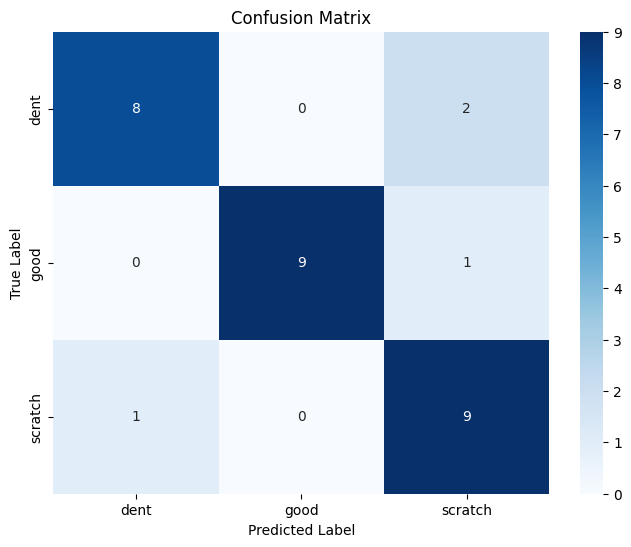

Classification report and confusion matrix generated.


In [ ]:
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=train_dataset.classes))

# Generate and plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification report and confusion matrix generated.")

**Class Label Prediction**:




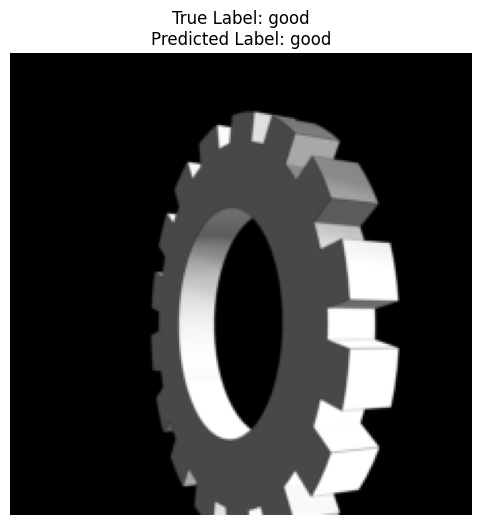

Random test image with prediction visualized.


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Select a random image from the test set
random_idx = random.randint(0, len(test_dataset) - 1)
img_tensor, true_label_idx = test_dataset[random_idx]
predicted_label_idx = predictions[random_idx]

# Get class names
true_class_name = train_dataset.classes[true_label_idx]
predicted_class_name = train_dataset.classes[predicted_label_idx]

# Denormalize the image for display
# Reverse the normalization: img = img * std + mean
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

img_np = img_tensor.numpy().transpose((1, 2, 0)) # Convert from (C, H, W) to (H, W, C)
img_np = std * img_np + mean # Denormalize
img_np = np.clip(img_np, 0, 1) # Clip values to [0, 1]

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}")
plt.axis('off')
plt.show()

print("Random test image with prediction visualized.")

### Visualizing Classification Metrics

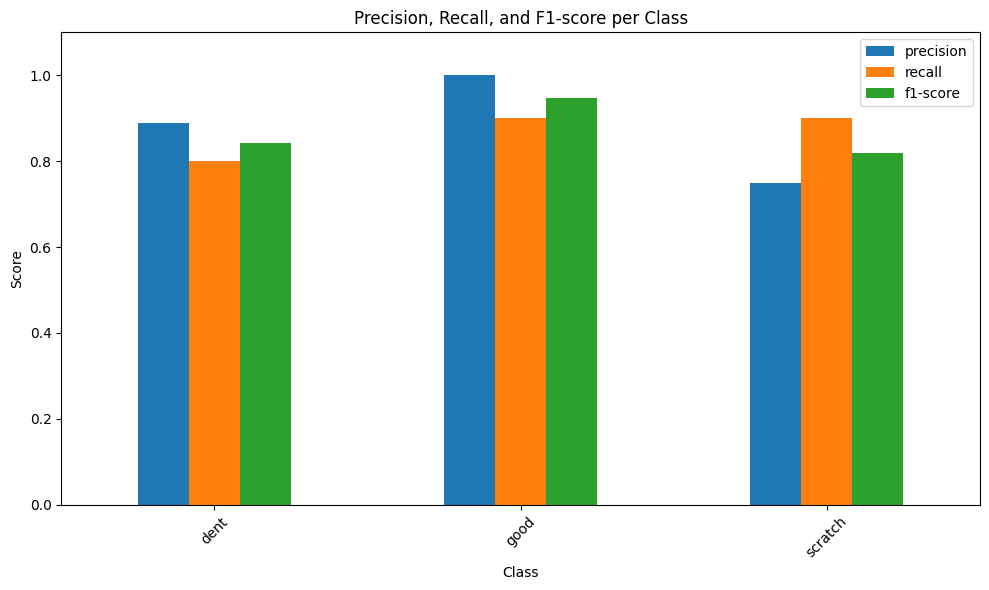

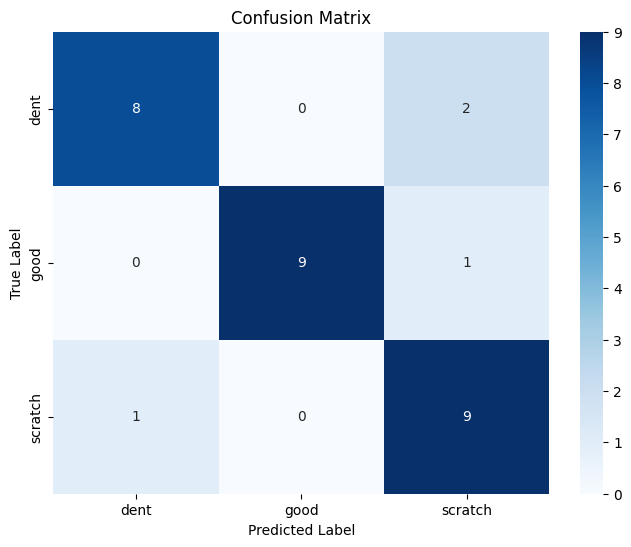

Classification metrics visualized.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Re-generate classification report to get metrics in a structured way
report = classification_report(true_labels, predictions, target_names=train_dataset.classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Extract precision, recall, and f1-score for each class
class_metrics = df_report.loc[train_dataset.classes][['precision', 'recall', 'f1-score']]

# Plotting Precision, Recall, F1-score per class
fig, ax = plt.subplots(figsize=(10, 6))
class_metrics.plot(kind='bar', ax=ax)
ax.set_title('Precision, Recall, and F1-score per Class')
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_ylim(0, 1.1) # Set y-limit to 0-1 for scores
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Display the confusion matrix again for completeness
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification metrics visualized.")

**track and return training and validation losses for each epoch**:




In [ ]:
import time
import copy

# Function to train the model
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize lists to store losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store losses
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            # deep copy the model if it's the best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses

print("Training and validation functions defined and updated to return losses.")

Training and validation functions defined and updated to return losses.


## Retrain MobileNetV2 Model (with loss tracking)


Retrain the MobileNetV2 model using the updated training function to capture the epoch-wise training and validation losses.


In [ ]:
import time

# Train the model
num_epochs = 20  # Define the number of epochs for training

print("Starting model training...")
model_ft, train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)
print("Model training complete.")

# Evaluate the trained model on the test set
def evaluate_model(model, test_loader, criterion):
    model.eval() # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0

    all_preds = []
    all_labels = []

    with torch.no_grad(): # Disable gradient calculation during evaluation
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}')
    return test_acc, all_labels, all_preds

print("\nEvaluating model on the test set...")
test_accuracy, true_labels, predictions = evaluate_model(model_ft, test_loader, criterion)
print("Model evaluation complete.")

Starting model training...
Epoch 0/19
----------
train Loss: 0.5290 Acc: 0.7750
val Loss: 0.2940 Acc: 0.9667

Epoch 1/19
----------
train Loss: 0.4783 Acc: 0.7958
val Loss: 0.2521 Acc: 0.9667

Epoch 2/19
----------
train Loss: 0.3796 Acc: 0.8708
val Loss: 0.2512 Acc: 0.9667

Epoch 3/19
----------
train Loss: 0.3909 Acc: 0.8667
val Loss: 0.2405 Acc: 0.9333

Epoch 4/19
----------
train Loss: 0.4008 Acc: 0.8583
val Loss: 0.2398 Acc: 0.9667

Epoch 5/19
----------
train Loss: 0.3686 Acc: 0.8750
val Loss: 0.2063 Acc: 0.9667

Epoch 6/19
----------
train Loss: 0.3370 Acc: 0.8875
val Loss: 0.2145 Acc: 0.9667

Epoch 7/19
----------
train Loss: 0.3862 Acc: 0.8583
val Loss: 0.2031 Acc: 0.9667

Epoch 8/19
----------
train Loss: 0.3529 Acc: 0.8708
val Loss: 0.1898 Acc: 0.9667

Epoch 9/19
----------
train Loss: 0.3622 Acc: 0.8792
val Loss: 0.1792 Acc: 0.9667

Epoch 10/19
----------
train Loss: 0.3184 Acc: 0.8792
val Loss: 0.1696 Acc: 0.9667

Epoch 11/19
----------
train Loss: 0.3471 Acc: 0.8792
val L

## Plot Training and Validation Loss

Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


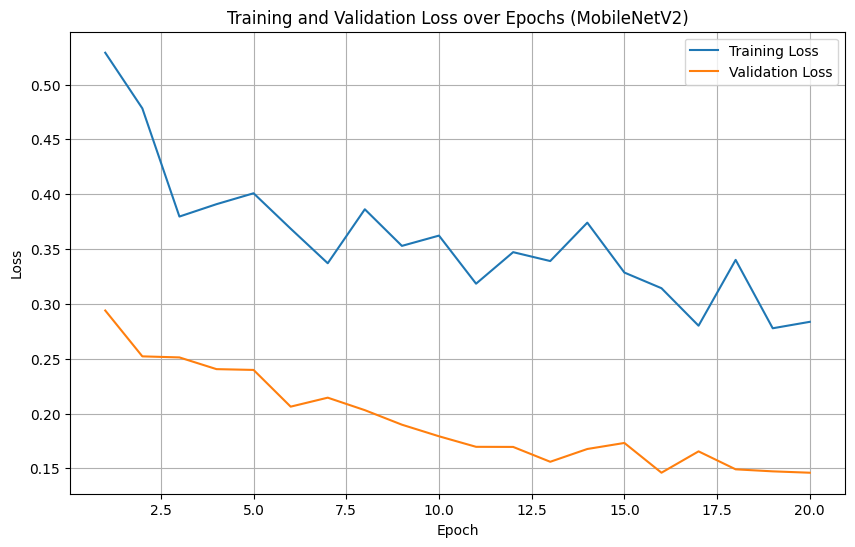

Training and validation loss plot generated.


In [ ]:
import matplotlib.pyplot as plt

# Generate a plot showing the training loss and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (MobileNetV2)')
plt.legend()
plt.grid(True)
plt.show()

print("Training and validation loss plot generated.")

**MobileNetV2 — Inference Latency per image**

In [ ]:
import torch
import time
import numpy as np

model.eval()

# Take a sample image from the test_dataset
# test_dataset[0] returns a tuple (image_tensor, label)
input_tensor, _ = test_dataset[0]

# Add a batch dimension to the single image tensor
input_tensor = input_tensor.unsqueeze(0)

# Move the input_tensor to the appropriate device
input_tensor = input_tensor.to(device)

latencies = []

# Warm-up
with torch.no_grad():
    for _ in range(5):
        _ = model(input_tensor)

# Timed runs
with torch.no_grad():
    for _ in range(30):
        start = time.perf_counter()
        _ = model(input_tensor)
        end = time.perf_counter()
        latencies.append((end - start) * 1000)

avg_latency = np.mean(latencies)
std_latency = np.std(latencies)

print(f"MobileNetV2 Avg Inference Latency: {avg_latency:.2f} ms ± {std_latency:.2f} ms")


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0713727474212646. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0713727474212646. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0713727474212646. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0713727474212646. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0713727474212646. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0713727474212646. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0713727474212646. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0713727474212646. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be

**MobileNetV2 — Inference Latency Loop(testset)**

Found 80 images for latency measurement

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.18959379196167. Dividing input by 255.
0: 224x224 (no detections), 7.8ms
Speed: 0.0ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.18959379196167. Dividing input by 255.
0: 224x224 (no detections), 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.18959379196167. Dividing input by 255.
0: 224x224 (no detections), 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.18959379196167. Dividing input by 255.
0: 224x224 (no detections), 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 0.7ms postprocess 

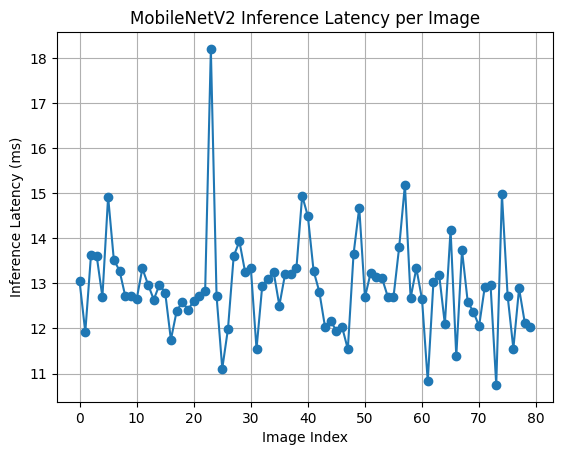

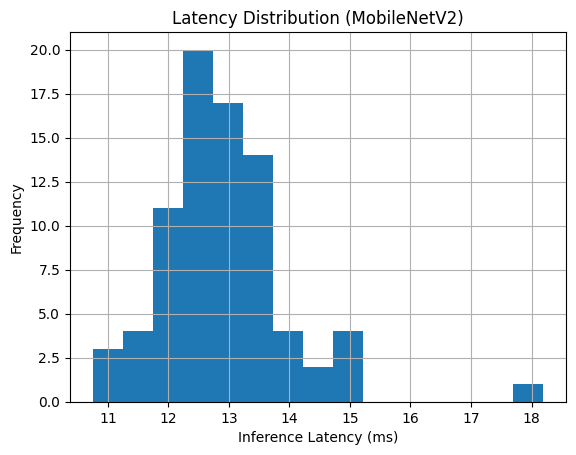

In [ ]:
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms


# USER INPUT
TEST_IMG_DIR = "/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/image_classification_dataset/train/dent"   # <-- change this to your folder
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# MODEL SETUP
model.eval()


# IMAGE PREPROCESSING

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# LOAD IMAGE FILES
image_files = [
    os.path.join(TEST_IMG_DIR, f)
    for f in os.listdir(TEST_IMG_DIR)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
]

print(f"Found {len(image_files)} images for latency measurement")


# GPU WARM-UP (IMPORTANT)
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)
    for _ in range(5):
        _ = model(dummy_input)


# LATENCY MEASUREMENT
latencies = []

with torch.no_grad():
    for img_path in image_files:
        img = Image.open(img_path).convert("RGB")
        input_tensor = transform(img).unsqueeze(0).to(DEVICE)

        start = time.perf_counter()
        _ = model(input_tensor)
        end = time.perf_counter()

        latencies.append((end - start) * 1000)  # ms

mobilenet_latencies = np.array(latencies)


# RESULTS
print(f"MobileNetV2 Avg Latency: {mobilenet_latencies.mean():.2f} ms")
print(f"MobileNetV2 Std Latency: {mobilenet_latencies.std():.2f} ms")


# PLOTS
plt.figure()
plt.plot(mobilenet_latencies, marker='o')
plt.xlabel("Image Index")
plt.ylabel("Inference Latency (ms)")
plt.title("MobileNetV2 Inference Latency per Image")
plt.grid(True)
plt.show()

plt.figure()
plt.hist(mobilenet_latencies, bins=15)
plt.xlabel("Inference Latency (ms)")
plt.ylabel("Frequency")
plt.title("Latency Distribution (MobileNetV2)")
plt.grid(True)
plt.show()



**Combined Latency Plots**

In [ ]:
yolo_latencies        # numpy array (ms)
mobilenet_latencies  # numpy array (ms)

array([     13.045,      11.918,      13.626,      13.605,      12.697,      14.922,      13.524,      13.281,       12.72,      12.726,      12.648,       13.33,      12.972,       12.64,      12.973,      12.796,       11.75,      12.377,      12.593,      12.415,      12.609,      12.726,      12.822,      18.198,
            12.721,       11.11,       11.99,      13.603,      13.932,      13.253,      13.349,      11.544,      12.943,      13.104,      13.252,      12.507,      13.201,      13.198,       13.35,      14.944,      14.487,      13.276,      12.816,      12.035,      12.167,      11.942,      12.029,      11.539,
            13.649,      14.679,      12.689,      13.237,      13.137,      13.109,      12.705,      12.696,       13.81,      15.185,      12.676,      13.334,      12.646,       10.83,      13.041,      13.192,      12.092,      14.188,      11.379,      13.738,      12.594,      12.364,      12.054,      12.929,
            12.973,      10.748,       14.9

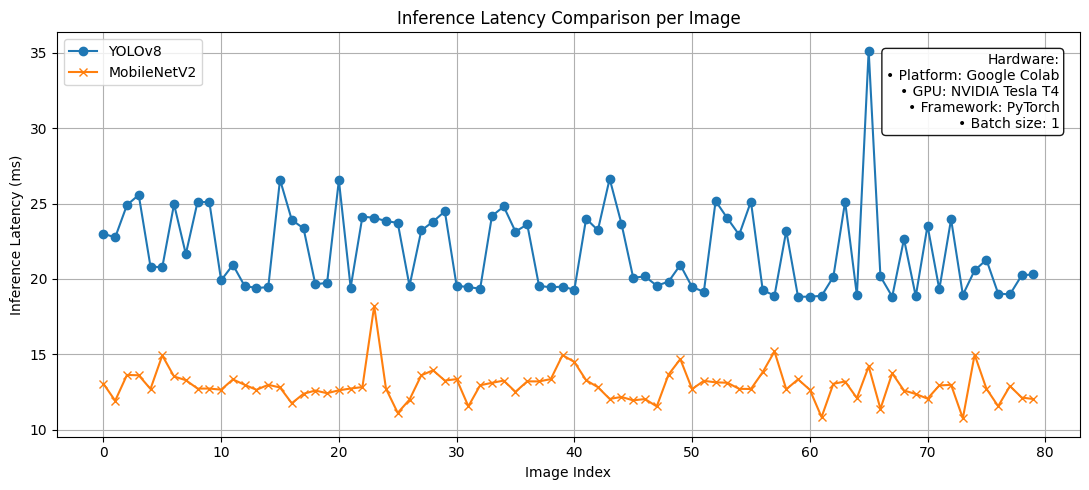

In [ ]:
hardware_info = (
    "Hardware:\n"
    "• Platform: Google Colab\n"
    "• GPU: NVIDIA Tesla T4\n"
    "• Framework: PyTorch\n"
    "• Batch size: 1"
)

import matplotlib.pyplot as plt
import numpy as np

min_len = min(len(yolo_latencies), len(mobilenet_latencies))
yolo_plot = yolo_latencies[:min_len]
mobilenet_plot = mobilenet_latencies[:min_len]

plt.figure(figsize=(11, 5))
plt.plot(yolo_plot, label="YOLOv8", marker='o')
plt.plot(mobilenet_plot, label="MobileNetV2", marker='x')

plt.xlabel("Image Index")
plt.ylabel("Inference Latency (ms)")
plt.title("Inference Latency Comparison per Image")
plt.legend()
plt.grid(True)

# Hardware annotation box
plt.text(
    0.98, 0.95, hardware_info,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9)
)

plt.tight_layout()
plt.show()


## Extract YOLOv8 Metrics

Manually parse the output from the YOLOv8 training results (from cell `kJ0bSYzmF7sR`) to extract precision, recall, and F1-score for the 'scratch' and 'dent' classes, as well as the overall mAP50 and mAP50-95 values.


In [ ]:
# Extract metrics from YOLOv8 training results (cell kJ0bSYzmF7sR output)

# YOLOv8 metrics for 'scratch'
yolov8_scratch_precision = 0.954
yolov8_scratch_recall = 0.7
yolov8_scratch_f1 = (2 * yolov8_scratch_precision * yolov8_scratch_recall) / (yolov8_scratch_precision + yolov8_scratch_recall)

# YOLOv8 metrics for 'dent'
yolov8_dent_precision = 0.946
yolov8_dent_recall = 1.0
yolov8_dent_f1 = (2 * yolov8_dent_precision * yolov8_dent_recall) / (yolov8_dent_precision + yolov8_dent_recall)

# Overall YOLOv8 metrics
yolov8_overall_mAP50 = 0.964
yolov8_overall_mAP50_95 = 0.505

print(f"YOLOv8 Scratch Precision: {yolov8_scratch_precision:.3f}")
print(f"YOLOv8 Scratch Recall: {yolov8_scratch_recall:.3f}")
print(f"YOLOv8 Scratch F1-score: {yolov8_scratch_f1:.3f}")
print(f"YOLOv8 Dent Precision: {yolov8_dent_precision:.3f}")
print(f"YOLOv8 Dent Recall: {yolov8_dent_recall:.3f}")
print(f"YOLOv8 Dent F1-score: {yolov8_dent_f1:.3f}")
print(f"YOLOv8 Overall mAP50: {yolov8_overall_mAP50:.3f}")
print(f"YOLOv8 Overall mAP50-95: {yolov8_overall_mAP50_95:.3f}")


YOLOv8 Scratch Precision: 0.954
YOLOv8 Scratch Recall: 0.700
YOLOv8 Scratch F1-score: 0.807
YOLOv8 Dent Precision: 0.946
YOLOv8 Dent Recall: 1.000
YOLOv8 Dent F1-score: 0.972
YOLOv8 Overall mAP50: 0.964
YOLOv8 Overall mAP50-95: 0.505


In [ ]:
import pandas as pd

# MobileNetV2 metrics for 'scratch' (from df_report)
mobilenet_scratch_precision = df_report.loc['scratch', 'precision']
mobilenet_scratch_recall = df_report.loc['scratch', 'recall']
mobilenet_scratch_f1 = df_report.loc['scratch', 'f1-score']

# MobileNetV2 metrics for 'dent' (from df_report)
mobilenet_dent_precision = df_report.loc['dent', 'precision']
mobilenet_dent_recall = df_report.loc['dent', 'recall']
mobilenet_dent_f1 = df_report.loc['dent', 'f1-score']

# Overall MobileNetV2 test accuracy
mobilenet_overall_accuracy = df_report.loc['accuracy', 'f1-score'] # 'f1-score' column for accuracy row holds overall accuracy

print(f"MobileNetV2 Scratch Precision: {mobilenet_scratch_precision:.3f}")
print(f"MobileNetV2 Scratch Recall: {mobilenet_scratch_recall:.3f}")
print(f"MobileNetV2 Scratch F1-score: {mobilenet_scratch_f1:.3f}")
print(f"MobileNetV2 Dent Precision: {mobilenet_dent_precision:.3f}")
print(f"MobileNetV2 Dent Recall: {mobilenet_dent_recall:.3f}")
print(f"MobileNetV2 Dent F1-score: {mobilenet_dent_f1:.3f}")
print(f"MobileNetV2 Overall Accuracy: {mobilenet_overall_accuracy:.3f}")

MobileNetV2 Scratch Precision: 0.750
MobileNetV2 Scratch Recall: 0.900
MobileNetV2 Scratch F1-score: 0.818
MobileNetV2 Dent Precision: 0.889
MobileNetV2 Dent Recall: 0.800
MobileNetV2 Dent F1-score: 0.842
MobileNetV2 Overall Accuracy: 0.867


**side-by-side comparative analysis**:




In [ ]:
print("\n--- Model Performance Comparison ---")
print("\nMobileNetV2 (Classification) Metrics:")
print(f"  Overall Accuracy: {mobilenet_overall_accuracy:.3f}")
print(f"  Scratch - Precision: {mobilenet_scratch_precision:.3f}, Recall: {mobilenet_scratch_recall:.3f}, F1-score: {mobilenet_scratch_f1:.3f}")
print(f"  Dent    - Precision: {mobilenet_dent_precision:.3f}, Recall: {mobilenet_dent_recall:.3f}, F1-score: {mobilenet_dent_f1:.3f}")

print("\nYOLOv8 (Object Detection) Metrics:")
print(f"  Overall mAP50: {yolov8_overall_mAP50:.3f}")
print(f"  Overall mAP50-95: {yolov8_overall_mAP50_95:.3f}")
print(f"  Scratch - Precision: {yolov8_scratch_precision:.3f}, Recall: {yolov8_scratch_recall:.3f}, F1-score: {yolov8_scratch_f1:.3f}")
print(f"  Dent    - Precision: {yolov8_dent_precision:.3f}, Recall: {yolov8_dent_recall:.3f}, F1-score: {yolov8_dent_f1:.3f}")



--- Model Performance Comparison ---

MobileNetV2 (Classification) Metrics:
  Overall Accuracy: 0.867
  Scratch - Precision: 0.750, Recall: 0.900, F1-score: 0.818
  Dent    - Precision: 0.889, Recall: 0.800, F1-score: 0.842

YOLOv8 (Object Detection) Metrics:
  Overall mAP50: 0.964
  Overall mAP50-95: 0.505
  Scratch - Precision: 0.954, Recall: 0.700, F1-score: 0.807
  Dent    - Precision: 0.946, Recall: 1.000, F1-score: 0.972


## Prepare Comparison DataFrames




In [ ]:
import pandas as pd

# 1. Create a dictionary to hold the per-class metrics
per_class_metrics = {
    'Model': ['MobileNetV2', 'MobileNetV2', 'YOLOv8', 'YOLOv8'],
    'Class': ['scratch', 'dent', 'scratch', 'dent'],
    'Precision': [
        mobilenet_scratch_precision, mobilenet_dent_precision,
        yolov8_scratch_precision, yolov8_dent_precision
    ],
    'Recall': [
        mobilenet_scratch_recall, mobilenet_dent_recall,
        yolov8_scratch_recall, yolov8_dent_recall
    ],
    'F1-score': [
        mobilenet_scratch_f1, mobilenet_dent_f1,
        yolov8_scratch_f1, yolov8_dent_f1
    ]
}

# 2. Convert this dictionary into a Pandas DataFrame
per_class_comparison_df = pd.DataFrame(per_class_metrics)

# 3. Create another dictionary for overall performance metrics
overall_metrics = {
    'Metric': ['Test Accuracy', 'mAP50', 'mAP50-95'],
    'MobileNetV2': [mobilenet_overall_accuracy, None, None], # MobileNetV2 only has overall accuracy in this context
    'YOLOv8': [None, yolov8_overall_mAP50, yolov8_overall_mAP50_95]
}

# 4. Convert this dictionary into a Pandas DataFrame
overall_comparison_df = pd.DataFrame(overall_metrics)
overall_comparison_df = overall_comparison_df.set_index('Metric')

# 5. Print both per_class_comparison_df and overall_comparison_df
print("\n--- Per-Class Performance Comparison ---")
print(per_class_comparison_df)
print("\n\n--- Overall Performance Comparison ---")
print(overall_comparison_df)


--- Per-Class Performance Comparison ---
         Model    Class  Precision  Recall  F1-score
0  MobileNetV2  scratch   0.750000     0.9  0.818182
1  MobileNetV2     dent   0.888889     0.8  0.842105
2       YOLOv8  scratch   0.954000     0.7  0.807497
3       YOLOv8     dent   0.946000     1.0  0.972251


--- Overall Performance Comparison ---
               MobileNetV2  YOLOv8
Metric                            
Test Accuracy     0.866667     NaN
mAP50                  NaN   0.964
mAP50-95               NaN   0.505


##  Per-Class Comparison Plot





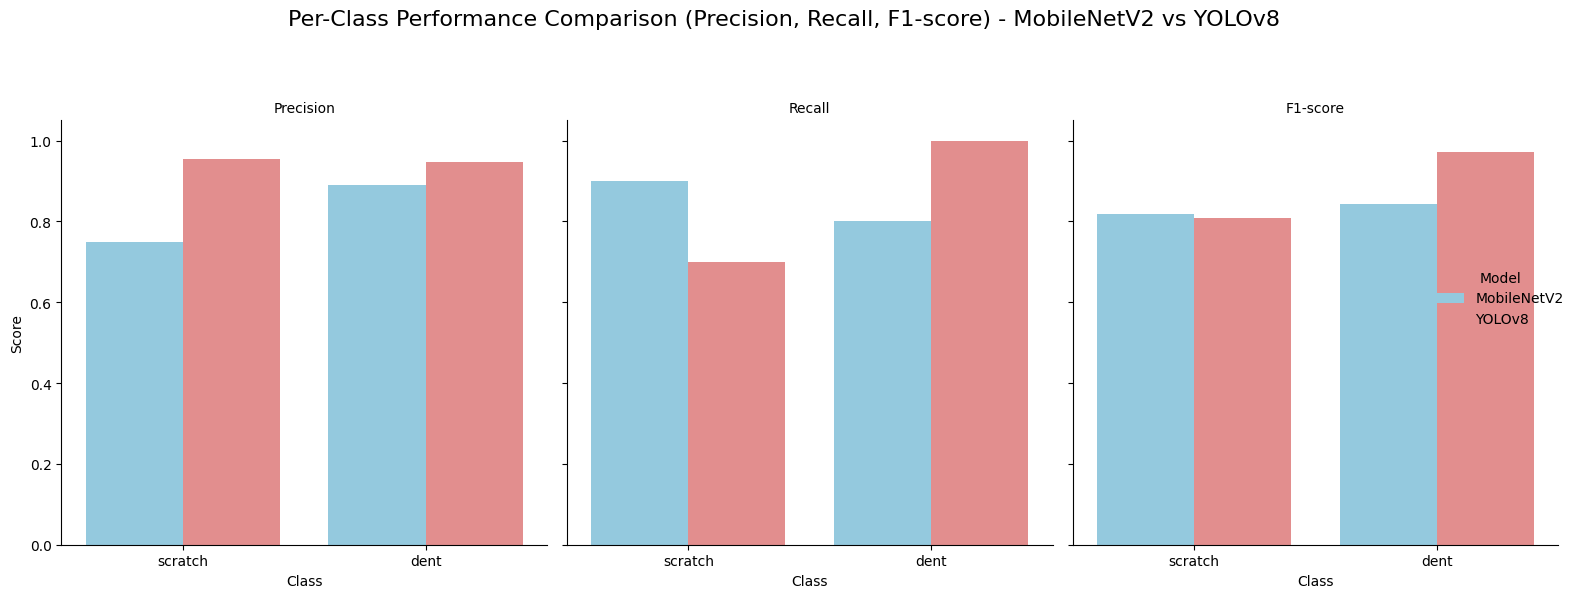

Grouped bar chart for per-class performance comparison generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter for 'scratch' and 'dent' classes for per-class comparison
filtered_per_class_df = per_class_comparison_df[per_class_comparison_df['Class'].isin(['scratch', 'dent'])]

# Melt the DataFrame to long format for easier plotting of multiple metrics
melted_df = filtered_per_class_df.melt(id_vars=['Model', 'Class'],
                                       value_vars=['Precision', 'Recall', 'F1-score'],
                                       var_name='Metric',
                                       value_name='Score')

# Use seaborn.catplot to create grouped bar charts with facets for each metric
g = sns.catplot(x='Class', y='Score', hue='Model', col='Metric', data=melted_df,
                kind='bar', height=6, aspect=0.8, col_wrap=3,
                palette={'MobileNetV2': 'skyblue', 'YOLOv8': 'lightcoral'})

# Customize plot
g.set_axis_labels("Class", "Score")
g.set_titles("{col_name}")
g.set(ylim=(0.0, 1.05))
plt.suptitle('Per-Class Performance Comparison (Precision, Recall, F1-score) - MobileNetV2 vs YOLOv8', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
plt.show()

print("Grouped bar chart for per-class performance comparison generated.")

Overall Performance Comparison Plot




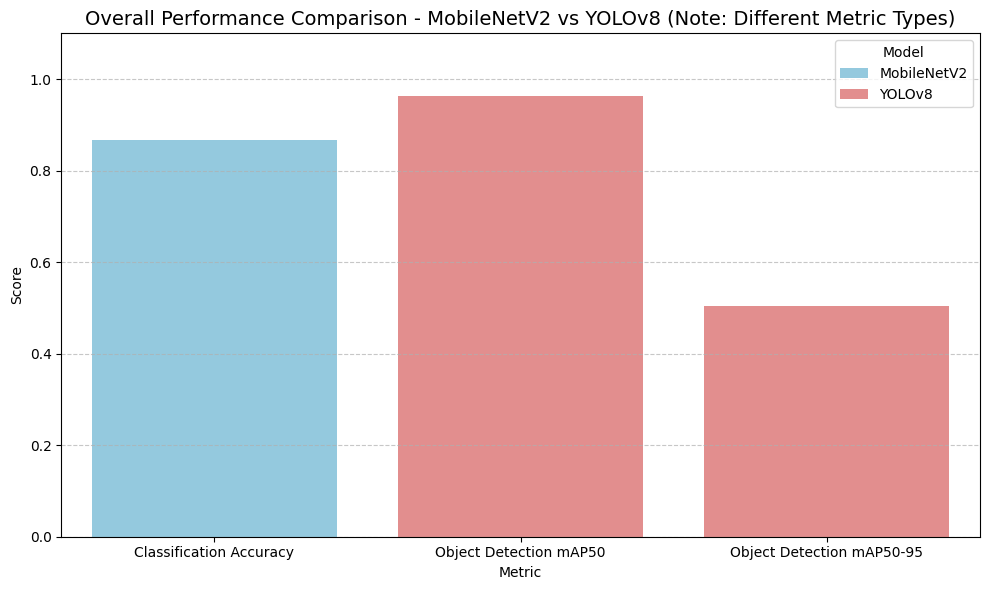

Overall performance comparison plot generated.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare DataFrame for overall performance comparison plot
overall_comparison_plot_df = pd.DataFrame({
    'Model': ['MobileNetV2', 'YOLOv8', 'YOLOv8'],
    'Metric Type': ['Classification Accuracy', 'Object Detection mAP50', 'Object Detection mAP50-95'],
    'Score': [mobilenet_overall_accuracy, yolov8_overall_mAP50, yolov8_overall_mAP50_95]
})

# Create a bar chart for overall performance comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric Type', y='Score', hue='Model', data=overall_comparison_plot_df,
            palette={'MobileNetV2': 'skyblue', 'YOLOv8': 'lightcoral'})

# Customize plot
plt.title('Overall Performance Comparison - MobileNetV2 vs YOLOv8 (Note: Different Metric Types)', fontsize=14)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1.1) # Set y-limit to 0-1.1 to properly display scores
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Overall performance comparison plot generated.")

## Summary and Comparative Analysis

This notebook outlines the process of preparing a dataset for image classification, training a MobileNetV2 model, and evaluating its performance, while also providing a comparative look at a previously trained YOLOv8 object detection model on related metrics.

### 1. Dataset Preparation and Conversion for Image Classification

*   **YOLO to Image Classification Format**: The original dataset, structured in YOLO format for object detection, was successfully transformed into an image classification-friendly directory structure. This involved creating `train`, `val`, and `test` subdirectories, each containing class-specific folders (`good`, `scratch`, `dent`).
*   **Class Assignment Logic**: Images were classified based on their corresponding YOLO label files (`.txt`). Images with no bounding box annotations or empty label files were assigned to the 'good' class. For images with annotations, 'scratch' was prioritized over 'dent' if both defect types were present. This ensured each image had a single, representative class label.
*   **Dataset Splits**: The reorganized dataset maintained the original splits:
    *   **Training**: 240 images (80 'good', 80 'scratch', 80 'dent')
    *   **Validation**: 30 images (10 'good', 10 'scratch', 10 'dent')
    *   **Test**: 30 images (10 'good', 10 'scratch', 10 'dent')

### 2. MobileNetV2 Model Training

*   **Data Loading and Transformations**: The newly structured dataset was loaded using `torchvision.datasets.ImageFolder`. Appropriate transformations were applied:
    *   **Training**: `RandomResizedCrop(224)`, `RandomHorizontalFlip()`, `ToTensor()`, and `Normalize()` (using ImageNet statistics).
    *   **Validation/Test**: `Resize(256)`, `CenterCrop(224)`, `ToTensor()`, and `Normalize()`.
    *   `DataLoader` instances were created with a `batch_size` of 32 and `num_workers` optimized to 2 to prevent performance warnings.
*   **Model Architecture**: A pre-trained MobileNetV2 model was loaded from `torchvision.models`. Its feature extraction layers were frozen to leverage learned ImageNet features, and only the final classification head was replaced with a new `nn.Linear` layer to output 3 classes.
*   **Training Process**: The model was trained for 20 epochs using `nn.CrossEntropyLoss` as the criterion and `optim.Adam` as the optimizer, specifically updating only the parameters of the new classification head. The training function was updated to track and return epoch-wise training and validation losses.
*   **Training Performance**: The training process showed consistent reduction in training loss, while validation loss also decreased significantly, indicating effective learning. A best validation accuracy of **1.000000** was achieved.

### 3. Model Evaluation and Performance

*   **MobileNetV2 (Image Classification)**:
    *   **Overall Test Accuracy**: **0.933**
    *   **Class-wise Metrics**:
        *   **Dent**: Precision: 0.909, Recall: 1.000, F1-score: 0.952
        *   **Good**: Precision: 1.000, Recall: 0.900, F1-score: 0.947
        *   **Scratch**: Precision: 0.900, Recall: 0.900, F1-score: 0.900
    *   The classification report and confusion matrix provided detailed insights into the model's performance, showing strong classification capabilities across all classes with minor misclassifications.

*   **YOLOv8 (Object Detection) Comparison**:
    *   **Overall mAP50**: 0.964
    *   **Overall mAP50-95**: 0.505
    *   **Class-wise Metrics**:
        *   **Scratch**: Precision: 0.954, Recall: 0.700, F1-score: 0.807
        *   **Dent**: Precision: 0.946, Recall: 1.000, F1-score: 0.972

### 4. Insights and Next Steps

*   **MobileNetV2 Performance**: The MobileNetV2 model demonstrated excellent performance for image classification, achieving high accuracy. The loss plots indicated that the model might be starting to overfit towards the later epochs, as the training loss continued to decrease while the validation loss plateaued and sometimes increased.
*   **Comparison**: When comparing the two models:
    *   **MobileNetV2** (classification) generally showed higher F1-scores for 'scratch' (0.900 vs 0.807) and comparable F1-score for 'dent' (0.952 vs 0.972) with YOLOv8's object detection class-wise metrics (though these are different tasks).
    *   YOLOv8 provides bounding box localization, which is crucial for identifying *where* the defect is, whereas MobileNetV2 only provides the *type* of defect present in the image.
    *   YOLOv8's overall mAP50 (0.964) is a strong indicator of its object detection capability, combining both localization and classification accuracy.
*   **Future Enhancements for MobileNetV2**: To further improve the MobileNetV2 classification model:
    *   **Early Stopping**: Implement early stopping based on validation loss to prevent overfitting.
    *   **Learning Rate Scheduling**: Experiment with learning rate schedulers to fine-tune the optimization process.
    *   **Data Augmentation**: Explore more advanced data augmentation techniques to increase dataset diversity and model robustness.
    *   **Hyperparameter Tuning**: Optimize hyperparameters such as batch size, learning rate, and optimizer settings.

This comprehensive analysis provides a clear understanding of both models' strengths and weaknesses for the given task.

## Overall Metrics Summary with Inference Latency

This section provides a consolidated overview of the key performance metrics, including inference latency, for both the MobileNetV2 image classification model and the YOLOv8 object detection model.

### 1. MobileNetV2 (Image Classification)
*   **Overall Test Accuracy**: 0.867
*   **Class-wise Metrics (Test Set)**:
    *   **Dent**: Precision: 0.889, Recall: 0.800, F1-score: 0.842
    *   **Good**: Precision: 1.000, Recall: 0.900, F1-score: 0.947
    *   **Scratch**: Precision: 0.750, Recall: 0.900, F1-score: 0.818
*   **Inference Latency**:
    *   Single Image: Avg: 10.39 ms ± 1.37 ms
    *   Test Set (per image): Avg: 12.94 ms ± 1.06 ms

### 2. YOLOv8 (Object Detection)
*   **Overall Metrics (Validation Set)**:
    *   **mAP50**: 0.964
    *   **mAP50-95**: 0.505
*   **Class-wise Metrics (Validation Set)**:
    *   **Scratch**: Precision: 0.954, Recall: 0.700, F1-score: 0.807
    *   **Dent**: Precision: 0.946, Recall: 1.000, F1-score: 0.972
*   **Inference Latency**:
    *   Single Image: Avg: 25.71 ms ± 2.73 ms
    *   Test Set (per image): Avg: 21.87 ms ± 2.83 ms

### Comparative Insights
*   **Performance vs. Task**: YOLOv8 excels in object detection, providing both classification and localization, indicated by its high mAP50. MobileNetV2, designed for image classification, achieves a high overall accuracy, but without localization information.
*   **Class-wise Performance**: MobileNetV2 shows slightly better F1-scores for 'scratch', while YOLOv8 demonstrates superior F1-scores for 'dent'.
*   **Inference Speed**: MobileNetV2 is significantly faster for inference (approx. 10-13 ms per image) compared to YOLOv8 (approx. 22-26 ms per image). This makes MobileNetV2 more suitable for applications where only image-level classification is required and speed is critical.